In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [4]:
# Transform each image by turning it into a tensor
MEAN_TRANSFORM = 0.5
STD_DEV_TRANSFORM = 0.5
mnist_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((MEAN_TRANSFORM,), (STD_DEV_TRANSFORM,))
])

TRAIN_BATCH_SIZE = 64

training_dataset = torchvision.datasets.MNIST(
    './data', train=True, download=True, transform=mnist_transforms)

TRAINLOADER = torch.utils.data.DataLoader(training_dataset,
                                          batch_size=TRAIN_BATCH_SIZE,
                                          shuffle=True)

https://debuggercafe.com/generating-mnist-digit-images-using-vanilla-gan-with-pytorch/

In [5]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [8]:
# function to train the discriminator network
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

# function to train the generator network
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [9]:
# learning parameters
batch_size = 512
epochs = 200
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator

generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [10]:
# optimizers
optim_g = torch.optim.Adam(generator.parameters(), lr=0.0002)
optim_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
# loss function
criterion = nn.BCELoss()

In [11]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch

In [12]:
generator.train()
discriminator.train()

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [13]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in enumerate(TRAINLOADER):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        # run the discriminator for k number of steps
        for step in range(k):
            data_fake = generator(create_noise(b_size, nz)).detach()
            data_real = image
            # train the discriminator network
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(create_noise(b_size, nz))
        # train the generator network
        loss_g += train_generator(optim_g, data_fake)
    # # create the final fake image for the epoch
    # generated_img = generator(noise).cpu().detach()
    # # make the images as grid
    # generated_img = make_grid(generated_img)
    
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

Epoch 0 of 200
Generator loss: 1.91246605, Discriminator loss: 1.13765645
Epoch 1 of 200
Generator loss: 1.29907858, Discriminator loss: 1.15912557
Epoch 2 of 200
Generator loss: 2.30861568, Discriminator loss: 0.82533503
Epoch 3 of 200
Generator loss: 2.63887286, Discriminator loss: 0.64856386
Epoch 4 of 200
Generator loss: 2.59257197, Discriminator loss: 0.60664707
Epoch 5 of 200
Generator loss: 2.41760659, Discriminator loss: 0.65374875
Epoch 6 of 200
Generator loss: 2.30634332, Discriminator loss: 0.67056793
Epoch 7 of 200
Generator loss: 2.22890306, Discriminator loss: 0.69213295
Epoch 8 of 200
Generator loss: 2.16524267, Discriminator loss: 0.71868026
Epoch 9 of 200
Generator loss: 2.03946686, Discriminator loss: 0.75543708
Epoch 10 of 200
Generator loss: 1.93666446, Discriminator loss: 0.81096941
Epoch 11 of 200
Generator loss: 1.85497653, Discriminator loss: 0.83233452
Epoch 12 of 200
Generator loss: 1.67981362, Discriminator loss: 0.87928677
Epoch 13 of 200
Generator loss: 1.5

In [15]:
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

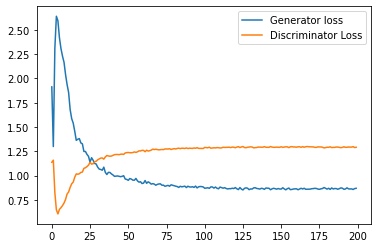

In [14]:
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
# plt.savefig('../outputs/loss.png')
plt.show()

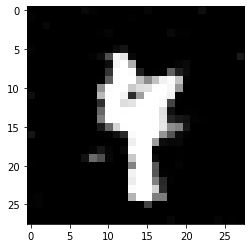

In [57]:
nz = 128

g_state_dict = torch.load("generator.pth",
                          map_location=lambda storage, loc: storage)
generator = Generator(nz)
generator.load_state_dict(g_state_dict)
d_state_dict = torch.load("discriminator.pth",
                          map_location=lambda storage, loc: storage)
discriminator = Discriminator()
discriminator.load_state_dict(d_state_dict)



with torch.no_grad():
    results = generator(torch.randn(1, nz))
    plt.imshow(results[0].reshape((28, 28)), cmap='gray')
    plt.show()

# LSI

In [38]:
from ribs.archives import GridArchive
archive = GridArchive([50, 50], [(0, 784), (0, 1)], dtype=np.float32) # size and whiteness

In [39]:
from ribs.emitters import GaussianEmitter
from ribs.emitters import GaussianEmitter

img_size = (28, 28)
flat_img_size = 784  # 28 * 28
batch_size = 30
emitters = [
    GaussianEmitter(
        archive,
        # Start with a grey image.
        np.full(nz, 0.5),
        0.5,
        # Bound the generated images to the pixel range.
        bounds=[(0, 1)] * nz,
        batch_size=batch_size,
    )
]

In [40]:
from ribs.optimizers import Optimizer

optimizer = Optimizer(archive, emitters)

In [41]:
total_itrs = 300_000
start_time = time.time()

for itr in range(1, total_itrs + 1):
    sols = optimizer.ask() # n_sol x sol_dim
    
    with torch.no_grad():
        generated_imgs = generator(torch.tensor(sols, 
            dtype=torch.float32).to(device)) # n_sol x 28 x 28
        objs = discriminator(generated_imgs).cpu().numpy()
        objs = objs.reshape(-1)

        generated_imgs = generated_imgs.cpu()\
                        .numpy().reshape((-1, flat_img_size))

        # normalize the values to [0, 1]
        normalized = (generated_imgs - np.min(generated_imgs))/ \
                     (np.max(generated_imgs) - np.min(generated_imgs))

        # the first bc is the "boldness" of the digit 
        # (i.e. number of white pixels)
        # we consider pixels with values larger than or equal to 0.5 as "white"
        digit_sizes = np.count_nonzero(
            normalized >= 0.5, axis=1).reshape(-1, 1) # n_sol x 1
        
        # the second bc is the "lightness" of the digit 
        # (i.e. how white the white pixels are)
        # we use the mean value of the "white" pixels here
        normalized[normalized < 0.5] = 0 # zero out "non-white" pixels
        digit_boldness = np.divide(
            np.sum(normalized, axis=1).reshape(-1, 1), 
            digit_sizes + 1) # n_sol x 1
        
        bcs = np.concatenate([digit_sizes, digit_boldness], axis=1)
    
    optimizer.tell(objs, bcs)
    
    if itr % 1000 == 0:
        print(f"Iteration {itr} complete after {time.time() - start_time} s")

Iteration 1000 complete after 3.4109790325164795 s
Iteration 2000 complete after 6.716419696807861 s
Iteration 3000 complete after 10.017097473144531 s
Iteration 4000 complete after 13.2870032787323 s
Iteration 5000 complete after 16.531917095184326 s
Iteration 6000 complete after 19.862351894378662 s
Iteration 7000 complete after 23.134551525115967 s
Iteration 8000 complete after 26.48351502418518 s
Iteration 9000 complete after 29.783445119857788 s
Iteration 10000 complete after 33.064698219299316 s
Iteration 11000 complete after 36.42537212371826 s
Iteration 12000 complete after 39.66795229911804 s
Iteration 13000 complete after 42.95108985900879 s
Iteration 14000 complete after 46.23010730743408 s
Iteration 15000 complete after 49.5576491355896 s
Iteration 16000 complete after 52.85071015357971 s
Iteration 17000 complete after 56.15930962562561 s
Iteration 18000 complete after 59.42505502700806 s
Iteration 19000 complete after 62.76455807685852 s
Iteration 20000 complete after 66.0

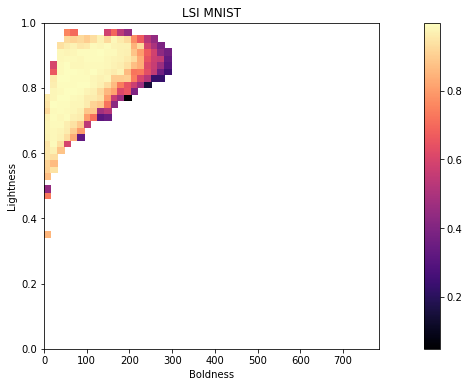

In [58]:
from ribs.visualize import grid_archive_heatmap

plt.figure(figsize=(8, 6))
grid_archive_heatmap(archive)
plt.title("LSI MNIST")
plt.xlabel("Boldness")
plt.ylabel("Lightness")
plt.show()

In [62]:
elites = archive.as_pandas().sort_values("index_1")
elites

,index_0,index_1,behavior_0,behavior_1,objective,solution_0,solution_1,solution_2,solution_3,solution_4,...,solution_118,solution_119,solution_120,solution_121,solution_122,solution_123,solution_124,solution_125,solution_126,solution_127
220,0,17,2.0,0.345933,0.852624,0.963687,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.351777,0.000000,0.601165,0.773175,0.977258,0.000000,1.000000,1.000000
228,0,23,5.0,0.473095,0.733039,0.000000,0.585358,1.000000,0.369714,0.873298,...,0.945405,0.120939,0.799109,0.000000,0.162634,0.373546,0.850384,0.039032,0.082848,0.994462
216,0,24,8.0,0.494489,0.442087,0.000000,0.943019,0.000000,0.000000,0.772661,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.174319,0.000000,0.000000,0.600450,0.194278
201,0,26,9.0,0.536747,0.864893,1.000000,1.000000,0.000000,0.222871,0.671391,...,0.866251,0.291984,0.000000,0.290326,0.866790,0.244639,0.017722,0.000000,0.753843,0.882285
195,0,27,8.0,0.551649,0.908324,0.754362,1.000000,1.000000,0.337354,0.780894,...,0.000000,0.000000,0.450985,0.000000,0.720012,1.000000,0.726308,0.000000,0.471895,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,4,48,65.0,0.960958,0.700909,1.000000,0.131151,1.000000,0.000000,0.754385,...,0.205444,1.000000,0.454368,0.000000,0.448210,0.930277,0.000000,1.000000,1.000000,0.000000
221,11,48,173.0,0.960364,0.534989,0.271537,0.072197,0.000000,1.000000,0.000000,...,1.000000,0.831454,0.000000,0.939062,0.180444,0.466917,0.000000,0.633418,0.207657,0.000000
172,10,48,164.0,0.962988,0.691107,0.404932,0.827960,0.859453,1.000000,0.746134,...,0.549965,0.104382,0.000000,1.000000,0.000000,0.488151,0.248832,0.000000,0.693918,0.000000
225,9,48,154.0,0.960331,0.586047,0.073457,0.000000,0.000000,1.000000,0.345764,...,1.000000,1.000000,0.022720,1.000000,0.203944,0.000000,0.218909,0.319906,0.161077,0.000000


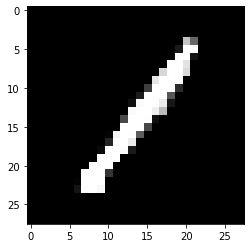

In [102]:
def show_img_at_index(x, y, elites):
    sol_row = elites[elites["index_0"] == x][elites["index_1"] == y]
    if sol_row.empty:
        print("Solution does not exist at the specified indexes.")
        return
    latent_vec = sol_row.iloc[0]["solution_0":].to_numpy()
    with torch.no_grad():
        img = generator(torch.tensor(latent_vec.reshape(1, 128), dtype=torch.float32))
        plt.imshow(img[0].reshape((28, 28)), cmap='gray')
        plt.show()


# show_img_at_index(0, 17, elites)
show_img_at_index(3, 48, elites)